In [24]:
# load the necessary packages 

import os
import scipy
import shutil
import numpy as np
import pandas as pd
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
cartopy.config['data_dir'] = os.getenv('CARTOPY_DIR', cartopy.config.get('data_dir'))

import plotly.express as px
import geopandas as gpd
from scipy.spatial import cKDTree

import imageio
import os
import io
import requests

import datetime as dt
from dateutil.relativedelta import *

import netCDF4
from netCDF4 import Dataset, num2date

import cmocean

import seaborn as sns
import pymannkendall as mk

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from matplotlib import pyplot as plt
%matplotlib inline

from PIL import Image  # To create gifs
from shapely.geometry import Point
from shapely.geometry import LineString

In [26]:
# Load the Excel file
file_path = '/Users/liav/Desktop/Jupyter/allstats.csv' 
allstats = pd.read_csv(file_path)
allstats

,Unnamed: 0,var,Day 1,Day 2,Day 3,Day 4,Day 5,Day 6,Day 7,Day 8,Day 9,var_name,position,stats,shift
0,0,temp_pos4_Mean,30.452438,30.304798,29.783731,29.542430,29.346487,29.207323,29.068980,29.126822,29.378609,temp,pos4,Mean,0
1,1,temp_pos4_Max,30.649218,30.611778,30.001358,29.683575,29.465958,29.295725,29.155552,29.307812,29.504040,temp,pos4,Max,0
2,2,temp_pos4_Min,30.110304,29.974293,29.457851,29.333520,29.189405,29.037859,28.946226,28.961296,29.231780,temp,pos4,Min,0
3,3,temp_pos5_Mean,30.368689,30.254457,29.811983,29.473957,29.264202,29.130770,29.010042,29.010029,29.255510,temp,pos5,Mean,0
4,4,temp_pos5_Max,30.649218,30.611778,30.013517,29.621355,29.465958,29.275011,29.162775,29.289953,29.492980,temp,pos5,Max,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,202,Chl_pos35_Max,0.068210,0.058190,0.057333,0.053044,0.042135,0.043165,0.039545,0.036130,0.039129,Chl,pos35,Max,-8
203,203,Chl_pos35_Min,0.027515,0.025786,0.022868,0.021744,0.017938,0.015646,0.013920,0.012721,0.019063,Chl,pos35,Min,-8
204,204,Chl_pos36_Mean,0.028977,0.029192,0.028755,0.030848,0.028296,0.028486,0.028939,0.031232,0.034393,Chl,pos36,Mean,-8
205,205,Chl_pos36_Max,0.032690,0.038512,0.042875,0.044485,0.034882,0.036477,0.034582,0.036198,0.039238,Chl,pos36,Max,-8


In [32]:
# Calculate the average of each row to normalise the entire dataset 
allstats['Row_Average'] = allstats.iloc[:, 2:10].mean(axis=1)
allstats

,Unnamed: 0,var,Day 1,Day 2,Day 3,Day 4,Day 5,Day 6,Day 7,Day 8,Day 9,var_name,position,stats,shift,Row_Average
0,0,temp_pos4_Mean,30.452438,30.304798,29.783731,29.542430,29.346487,29.207323,29.068980,29.126822,29.378609,temp,pos4,Mean,0,29.604126
1,1,temp_pos4_Max,30.649218,30.611778,30.001358,29.683575,29.465958,29.295725,29.155552,29.307812,29.504040,temp,pos4,Max,0,29.771372
2,2,temp_pos4_Min,30.110304,29.974293,29.457851,29.333520,29.189405,29.037859,28.946226,28.961296,29.231780,temp,pos4,Min,0,29.376344
3,3,temp_pos5_Mean,30.368689,30.254457,29.811983,29.473957,29.264202,29.130770,29.010042,29.010029,29.255510,temp,pos5,Mean,0,29.540516
4,4,temp_pos5_Max,30.649218,30.611778,30.013517,29.621355,29.465958,29.275011,29.162775,29.289953,29.492980,temp,pos5,Max,0,29.761196
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,202,Chl_pos35_Max,0.068210,0.058190,0.057333,0.053044,0.042135,0.043165,0.039545,0.036130,0.039129,Chl,pos35,Max,-8,0.049719
203,203,Chl_pos35_Min,0.027515,0.025786,0.022868,0.021744,0.017938,0.015646,0.013920,0.012721,0.019063,Chl,pos35,Min,-8,0.019767
204,204,Chl_pos36_Mean,0.028977,0.029192,0.028755,0.030848,0.028296,0.028486,0.028939,0.031232,0.034393,Chl,pos36,Mean,-8,0.029341
205,205,Chl_pos36_Max,0.032690,0.038512,0.042875,0.044485,0.034882,0.036477,0.034582,0.036198,0.039238,Chl,pos36,Max,-8,0.037588


In [34]:
# Create a new DataFrame with the same first two columns
norm_allstats = allstats.copy()

# Subtract each entry from the row average for columns 2 to 10
standardized_columns = allstats.iloc[:, 2:11].subtract(allstats['Row_Average'], axis=0)

# Add the standardised columns to the new DataFrame
# norm_allstats = pd.concat([norm_allstats, standardized_columns], axis=1)
# norm_allstats
standardized_columns['shift'] = norm_allstats['shift']
standardized_columns['stats'] = norm_allstats['stats']
standardized_columns['position'] = norm_allstats['position']
standardized_columns['var_name'] = norm_allstats['var_name']
new_norm = standardized_columns.copy()
new_norm

,Day 1,Day 2,Day 3,Day 4,Day 5,Day 6,Day 7,Day 8,Day 9,shift,stats,position,var_name
0,0.848312,0.700672,0.179605,-0.061696,-0.257639,-0.396803,-0.535146,-0.477304,-0.225517,0,Mean,pos4,temp
1,0.877846,0.840406,0.229986,-0.087797,-0.305414,-0.475647,-0.615820,-0.463560,-0.267332,0,Max,pos4,temp
2,0.733960,0.597949,0.081507,-0.042824,-0.186939,-0.338485,-0.430118,-0.415048,-0.144564,0,Min,pos4,temp
3,0.828173,0.713941,0.271467,-0.066559,-0.276314,-0.409746,-0.530474,-0.530487,-0.285006,0,Mean,pos5,temp
4,0.888022,0.850582,0.252321,-0.139841,-0.295238,-0.486185,-0.598421,-0.471243,-0.268216,0,Max,pos5,temp
...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,0.018491,0.008471,0.007614,0.003325,-0.007584,-0.006554,-0.010174,-0.013589,-0.010590,-8,Max,pos35,Chl
203,0.007748,0.006018,0.003101,0.001977,-0.001829,-0.004121,-0.005847,-0.007047,-0.000705,-8,Min,pos35,Chl
204,-0.000364,-0.000149,-0.000586,0.001507,-0.001045,-0.000855,-0.000401,0.001892,0.005052,-8,Mean,pos36,Chl
205,-0.004898,0.000924,0.005287,0.006898,-0.002706,-0.001111,-0.003006,-0.001389,0.001650,-8,Max,pos36,Chl


In [46]:
# Creating a function to generate all the dataframes for each variable & Stat

def get_indices(lst, targets):
    return list(filter(lambda x: lst[x] in targets, range(len(lst))))
    
def getVarStat(vname, stat):
    '''
    Extract from the dataframe the required values
    '''
    
    idx = get_indices(new_norm['var_name'], [vname])
    tmpdf = new_norm.iloc[idx].reset_index()
    del tmpdf['index']
    tmpdf
    
    idx = get_indices(tmpdf['stats'], [stat])
    tmpStat = tmpdf.iloc[idx].reset_index()
    del tmpStat['index']
    
    return tmpStat

# Creating a function to generate the trendlines of the anomalies 

def getTrend(df):
    tmp = []
    shiftx = []
    for pos in range(len(df)):
        tmpval = df.iloc[pos].values[0:9]
        ishift = df.iloc[pos].values[-4]
        x = np.arange(len(tmpval))+ishift
        tmp.append(tmpval)
        shiftx.append(x)
    xscatter = np.asarray(shiftx, dtype=float).flatten()
    yscatter = np.asarray(tmp, dtype=float).flatten()
    ind = np.argsort(xscatter)
    fit = np.polyfit(xscatter[ind], yscatter[ind], deg=20) 
    p = np.poly1d(fit) 

    return [xscatter[ind],p(xscatter[ind])]

# Creating a function to generate the scatter plots & trendlines of the anomalies 

def plotVarStat(df):
    tmp = []
    shiftx = []
    for pos in range(len(df)):
        tmpval = df.iloc[pos].values[0:9]
        ishift = df.iloc[pos].values[-4]
        x = np.arange(len(tmpval))+ishift
        tmp.append(tmpval)
        shiftx.append(x)
        plt.scatter(x, tmpval)
    xscatter = np.asarray(shiftx, dtype=float).flatten()
    yscatter = np.asarray(tmp, dtype=float).flatten()
    ind = np.argsort(xscatter)
    fit = np.polyfit(xscatter[ind], yscatter[ind], deg=20) 
    p = np.poly1d(fit) 
    plt.plot(xscatter[ind],p(xscatter[ind]),"r--", lw=2) 
    plt.show()

    return [xscatter[ind],p(xscatter[ind])]

In [48]:
chl_min = getVarStat('Chl','Min')
chl_mean = getVarStat('Chl','Mean')
chl_max = getVarStat('Chl','Max')

temp_min = getVarStat('temp','Min')
temp_mean = getVarStat('temp','Mean')
temp_max = getVarStat('temp','Max')

Secchi_min = getVarStat('Secchi','Min')
Secchi_mean = getVarStat('Secchi','Mean')
Secchi_max = getVarStat('Secchi','Max')

/var/folders/hk/zsnq07m15bj1ldz1jnp2l_qc0000gn/T/ipykernel_2858/3311163504.py:56: RankWarning: Polyfit may be poorly conditioned
  fit = np.polyfit(xscatter[ind], yscatter[ind], deg=20)


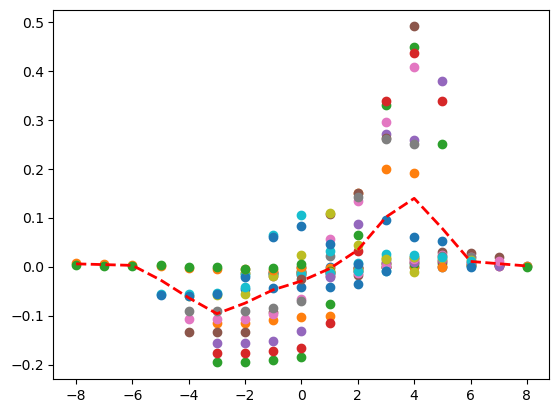

/var/folders/hk/zsnq07m15bj1ldz1jnp2l_qc0000gn/T/ipykernel_2858/3311163504.py:36: RankWarning: Polyfit may be poorly conditioned
  fit = np.polyfit(xscatter[ind], yscatter[ind], deg=20)
/var/folders/hk/zsnq07m15bj1ldz1jnp2l_qc0000gn/T/ipykernel_2858/3311163504.py:36: RankWarning: Polyfit may be poorly conditioned
  fit = np.polyfit(xscatter[ind], yscatter[ind], deg=20)
/var/folders/hk/zsnq07m15bj1ldz1jnp2l_qc0000gn/T/ipykernel_2858/3311163504.py:36: RankWarning: Polyfit may be poorly conditioned
  fit = np.polyfit(xscatter[ind], yscatter[ind], deg=20)
/var/folders/hk/zsnq07m15bj1ldz1jnp2l_qc0000gn/T/ipykernel_2858/3311163504.py:36: RankWarning: Polyfit may be poorly conditioned
  fit = np.polyfit(xscatter[ind], yscatter[ind], deg=20)
/var/folders/hk/zsnq07m15bj1ldz1jnp2l_qc0000gn/T/ipykernel_2858/3311163504.py:36: RankWarning: Polyfit may be poorly conditioned
  fit = np.polyfit(xscatter[ind], yscatter[ind], deg=20)
/var/folders/hk/zsnq07m15bj1ldz1jnp2l_qc0000gn/T/ipykernel_2858/331116

In [50]:
min_chl = plotVarStat(chl_min) # only this line outputs a scatter plots, the rest are just trendlines 
mean_chl = getTrend(chl_mean)
max_chl = getTrend(chl_max)

min_t = getTrend(temp_min)
mean_t = getTrend(temp_mean)
max_t = getTrend(temp_max)

min_se = getTrend(Secchi_min)
mean_se = getTrend(Secchi_mean)
max_se = getTrend(Secchi_max)

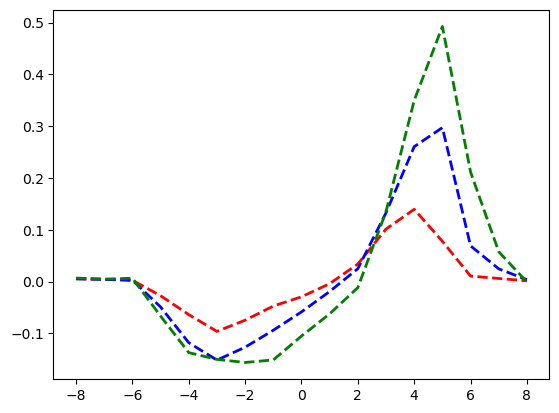

In [52]:
# plotting the trendlines of Chlorophyll-a 
plt.plot(min_chl[0],min_chl[1],"r--", lw=2) 
plt.plot(mean_chl[0],mean_chl[1],"b--", lw=2) 
plt.plot(max_chl[0],max_chl[1],"g--", lw=2) 

plt.show()

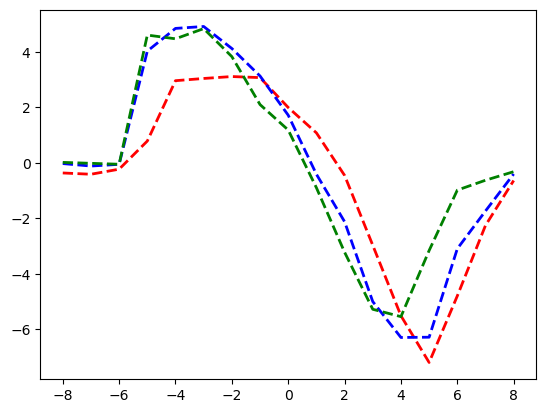

In [54]:
# plotting trendlines of Secchi 
plt.plot(min_se[0],min_se[1],"r--", lw=2) 
plt.plot(mean_se[0],mean_se[1],"b--", lw=2) 
plt.plot(max_se[0],max_se[1],"g--", lw=2) 

plt.show()

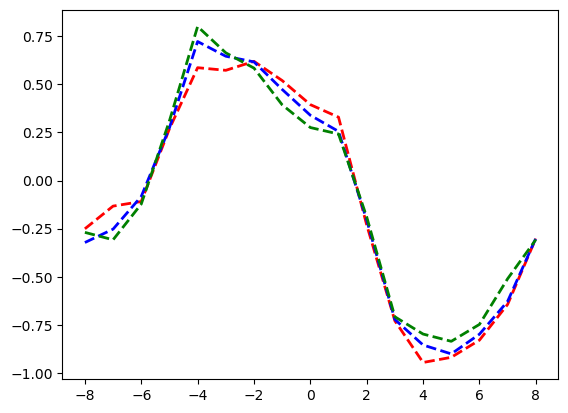

In [182]:
# plotting trendlines of temperature 
plt.plot(min_t[0],min_t[1],"r--", lw=2) 
plt.plot(mean_t[0],mean_t[1],"b--", lw=2) 
plt.plot(max_t[0],max_t[1],"g--", lw=2) 

plt.show()

In [56]:
# next steps:
# look at the anomalies in another year/month (when there is no cyclone) - 
# and check what is the trend and what are the anomalies we should expect - how different is it from the cyclone time?
# compare: 
# - 22 days before & after cyclone
# - March 2016 and March 2018

# for the temp graph:
# fix the colours and make points transparent
# use temp as an example, for the rest of the variables just present trendlines (no need for scatter)